# Azure AI Search with OpenAI's New Text-Embedding-3 Large Model

In this notebook, I'll show you how to use Azure OpenAI Service to generate embeddings using the latest and highest performing model from OpenAI, `text-embedding-3-large` and how to store these in Azure AI Search.

## Install libraries

In [5]:
! pip install azure-search-documents openai python-dotenv azure-identity langchain tiktoken --quiet

## Configure Azure OpenAI Settings

This section guides you through setting up authentication for Azure OpenAI, allowing you to securely interact with the service using either Azure Active Directory (AAD) or an API key. Before proceeding, ensure you have your Azure OpenAI endpoint and credentials ready. For detailed instructions on setting up AAD with Azure OpenAI, refer to the [official documentation](https://learn.microsoft.com/azure/ai-services/openai/how-to/managed-identity).

In [6]:
import os
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
from openai import AzureOpenAI

# Set up OpenAI client based on environment variables
load_dotenv()
AZURE_OPENAI_ENDPOINT: str = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY: str = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_API_VERSION: str = "2023-05-15"
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME: str = os.getenv(
    "AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME"
)


credential = DefaultAzureCredential()
token_provider = get_bearer_token_provider(
    credential, "https://cognitiveservices.azure.com/.default"
)

# Set this flag to True if you are using Azure Active Directory
use_aad_for_aoai = False

if use_aad_for_aoai:
    # Use Azure Active Directory (AAD) authentication
    client = AzureOpenAI(
        azure_endpoint=AZURE_OPENAI_ENDPOINT,
        api_version=AZURE_OPENAI_API_VERSION,
        azure_ad_token_provider=token_provider,
    )
else:
    # Use API key authentication
    client = AzureOpenAI(
        api_key=AZURE_OPENAI_API_KEY,
        api_version=AZURE_OPENAI_API_VERSION,
        azure_endpoint=AZURE_OPENAI_ENDPOINT,
    )

## Generate Embedding Functions for different sizes

The `text-embedding-3-large` supports variable dimensions with a range of 1:3072 using a technique called Matryoshka Representation Learning(https://arxiv.org/abs/2205.13147), - let's t-shirt size to easily compare them.

In [7]:
def generate_small_embedding(text: str):
    # Generate 256d embeddings for the provided text
    embeddings_response = client.embeddings.create(
        model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME, input=text, dimensions=256
    )
    return embeddings_response.data[0].embedding

def generate_medium_embedding(text: str):
    # Generate 1536d embeddings for the provided text
    embeddings_response = client.embeddings.create(
        model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME, input=text, dimensions=1536
    )
    return embeddings_response.data[0].embedding

def generate_large_embedding(text: str):
    # Generate 3072d embeddings for the provided text
    embeddings_response = client.embeddings.create(
        model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME, input=text, dimensions=3072
    )
    return embeddings_response.data[0].embedding


### Verify the dimension length

In [8]:
print(len(generate_small_embedding("Hello, world!")))
print(len(generate_medium_embedding("Hello, world!")))
print(len(generate_large_embedding("Hello, world!")))

256
1536
3072


### Calculate the raw vector size in Bytes

In [9]:
import sys

def print_vector_size(text: str, generator_function, description: str):
    # Generate an embedding for the text using the specified generator function
    embedding_vector = generator_function(text)
    
    # Measure the size of the vector embedding in bytes
    vector_size_bytes = sys.getsizeof(embedding_vector)
    
    # Print the size
    print(f"Size of the {description} vector embedding in bytes: {vector_size_bytes}")

# Example text
text = "Hello, world!"

# Print the size for each type of embedding
print_vector_size(text, generate_small_embedding, "small")
print_vector_size(text, generate_medium_embedding, "medium")
print_vector_size(text, generate_large_embedding, "large")


Size of the small vector embedding in bytes: 2104
Size of the medium vector embedding in bytes: 12344
Size of the large vector embedding in bytes: 24632


## Embedding Size Comparison

We have generated embeddings for a given text using three different dimensionalities: small (256d), medium (1536d), and large (3072d). The sizes of these embeddings in memory, as measured in bytes, are as follows:

- Small (256d) Embedding Size: 2104 bytes
- Medium (1536d) Embedding Size: 12344 bytes
- Large (3072d) Embedding Size: 24632 bytes

### Relative Differences

When comparing the embedding sizes relative to the medium (1536d) embedding:

- The **small (256d) embedding** is significantly smaller than the medium embedding. Specifically, it is approximately `((12344 - 2104) / 12344) * 100 ≈ 82.96%` smaller. This highlights the efficiency of using smaller embeddings for applications where memory usage is a critical constraint, though it may come at the cost of losing some detail or expressive power.

- The **large (3072d) embedding** is larger than the medium embedding. It is approximately `((24632 - 12344) / 12344) * 100 ≈ 99.41%` larger. The increased size of the large embeddings suggests a higher level of detail or expressive power, which can be beneficial for tasks requiring high accuracy


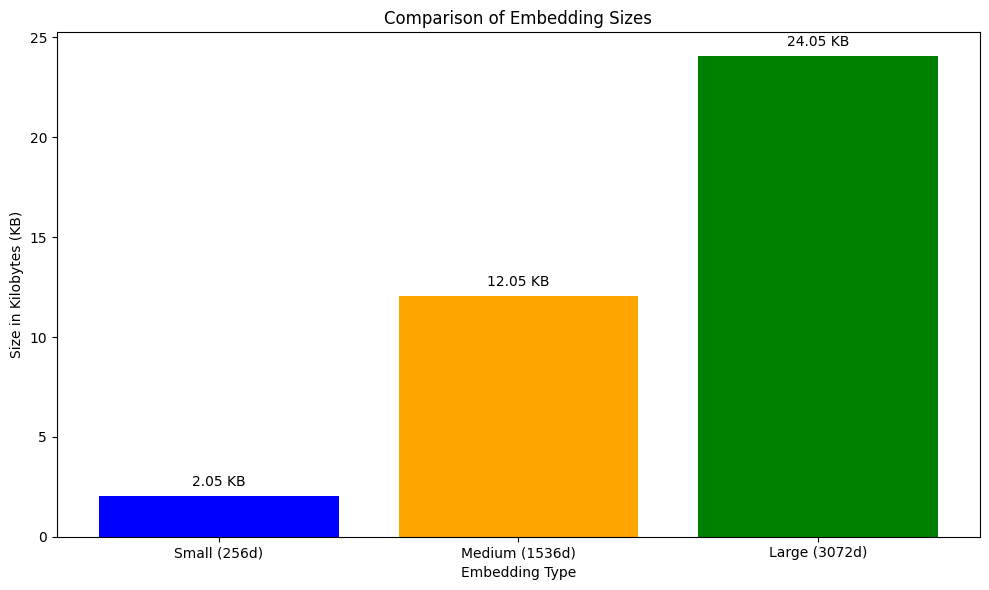

In [10]:
import matplotlib.pyplot as plt

# Embedding names
embeddings = ['Small (256d)', 'Medium (1536d)', 'Large (3072d)']

# Sizes in bytes (from your previous output)
sizes_bytes = [2104, 12344, 24632]

# Convert sizes to kilobytes for easier interpretation
sizes_kb = [size / 1024 for size in sizes_bytes]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(embeddings, sizes_kb, color=['blue', 'orange', 'green'])

# Add title and labels
plt.title('Comparison of Embedding Sizes')
plt.ylabel('Size in Kilobytes (KB)')
plt.xlabel('Embedding Type')

# Display the values on top of the bars
for i, size in enumerate(sizes_kb):
    plt.text(i, size + 0.5, f'{size:.2f} KB', ha='center')

# Show the plot
plt.tight_layout()
plt.show()


Let's see how using these embeddings affect our storage size and vector index size in Azure AI Search.

## Configure an Azure AI Search vector index

This section explains how to set up the Azure AI Search client for integrating with the Vector Store feature. You can locate your Azure AI Search service details in the Azure Portal or programmatically via the [Search Management SDK](https://learn.microsoft.com/rest/api/searchmanagement/).

Additionally, this demonstrates how to define and create a search index using the SearchIndexClient from the Azure AI Search Python SDK. For more details, visit our documentation on how to [Create a Vector Index](https://learn.microsoft.com/azure/search/vector-search-how-to-create-index?.tabs=config-2023-11-01%2Crest-2023-11-01%2Cpush%2Cportal-check-index).

In [11]:
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents import SearchClient
from azure.search.documents.indexes.models import (
    SearchIndex,
    SimpleField,
    SearchableField,
    SearchField,
    SearchFieldDataType,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile,
    VectorSearchAlgorithmKind,
)
from azure.identity import DefaultAzureCredential
import os

# Load environment variables
search_service_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
search_service_api_key = os.getenv("AZURE_SEARCH_ADMIN_KEY")

# Index names and their corresponding vector dimensions
index_info = {
    "small": {"name": "index-256d", "dimension": 256},
    "medium": {"name": "index-1536d", "dimension": 1536},
    "large": {"name": "index-3072d", "dimension": 3072},
}

# Authentication method flag
use_aad_for_search = True  # Set based on your authentication method

# Choose the correct credential based on your authentication method
credential = (
    DefaultAzureCredential()
    if use_aad_for_search
    else AzureKeyCredential(search_service_api_key)
)

# Initialize the SearchIndexClient for creating indexes
index_client = SearchIndexClient(
    endpoint=search_service_endpoint, credential=credential
)


# Function to create or update indexes
def create_or_update_index(index_name, dimensions):
    fields = [
        SimpleField(name="id", type=SearchFieldDataType.String, key=True),
        SearchableField(name="text", type=SearchFieldDataType.String),
        SearchField(
            name="vector",
            type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
            vector_search_dimensions=dimensions,
            vector_search_profile_name="my-vector-profile",
        ),
    ]

    vector_search = VectorSearch(
        algorithms=[
            HnswAlgorithmConfiguration(
                name="my-hnsw", kind=VectorSearchAlgorithmKind.HNSW
            )
        ],
        profiles=[
            VectorSearchProfile(
                name="my-vector-profile", algorithm_configuration_name="my-hnsw"
            )
        ],
    )

    index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)
    result = index_client.create_or_update_index(index=index)
    print(f"{result.name} created with {dimensions} dimensions")


# Create or update each index and initialize SearchClient instances
search_clients = {}
for size, info in index_info.items():
    create_or_update_index(info["name"], info["dimension"])
    search_clients[size] = SearchClient(
        endpoint=search_service_endpoint, index_name=info["name"], credential=credential
    )

# Now search_clients dictionary contains SearchClient instances for each index size

index-256d created with 256 dimensions
index-1536d created with 1536 dimensions
index-3072d created with 3072 dimensions


## Load Data

Let's leverage the state of the union text file in the data folder in the repos root directory. We will leverage langchain for loading and chunking this document.

In [12]:
# Correcting the file open syntax
with open('./data/state_of_the_union.txt', 'r', encoding='utf-8') as file:
    text_content = file.read()
    
# Now text_content contains the content of the state of the union address

Let's use the LangChain CharacterTextSplitter and split by every 100 tokens (just to keep thigns simple)

In [13]:
from langchain.text_splitter import CharacterTextSplitter

# Initialize the text splitter with a specific chunk size
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=0
)
texts = text_splitter.split_text(text_content)
# Print the total number of chunks
print(f"Total number of chunks: {len(texts)}")

Total number of chunks: 106


In [14]:
# Print the first chunk
print("First chunk:", texts[0])

First chunk: Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  

Last year COVID-19 kept us apart. This year we are finally together again. 

Tonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. 

With a duty to one another to the American people to the Constitution.


# Generating Text Embeddings with Azure OpenAI Service

This script processes text chunks using Azure OpenAI's embedding functions to generate embeddings, organizing the results into Pandas DataFrames for analysis or storage. A helper function, create_embedding_df, iterates over text inputs to create embeddings of varying dimensions (small, medium, large), resulting in three distinct DataFrames that facilitate comparative analysis or further application.


In [15]:
import pandas as pd

# Helper function to process texts and create a DataFrame
def create_embedding_df(texts, embedding_function):
    data = []
    for i, text in enumerate(texts):
        # Generate embedding
        vector = embedding_function(text)
        # Append the data with an ID, the original text, and the generated vector
        data.append({"id": str(i), "text": text, "vector": vector})
    # Create a DataFrame
    df = pd.DataFrame(data, columns=["id", "text", "vector"])
    return df

# Process the texts with each embedding function and create the DataFrames
df_small = create_embedding_df(texts, generate_small_embedding)
df_medium = create_embedding_df(texts, generate_medium_embedding)
df_large = create_embedding_df(texts, generate_large_embedding)

# Now, df_small, df_medium, and df_large DataFrames contain the vector embeddings for each chunk of text.


In order to upload these to Azure AI Search, we must convert the data frames to a list of dictionaries. 

In [16]:
# Convert DataFrames to lists of dictionaries
documents_small = df_small.to_dict('records')
documents_medium = df_medium.to_dict('records')
documents_large = df_large.to_dict('records')


Now that we have are data in a readyily avaialble format ready to import to Azure AI Search, let's create a vector index.

## Upload Data to Azure AI Search Index


In [17]:
# Define a dictionary mapping index sizes to their corresponding documents
documents_dict = {
    "small": documents_small,
    "medium": documents_medium,
    "large": documents_large,
}

# Loop through each index size and upload the documents
for size, documents in documents_dict.items():
    upload_result = search_clients[size].upload_documents(documents=documents)
    print(f"Uploaded successfully to {size} index")


Uploaded successfully to small index
Uploaded successfully to medium index
Uploaded successfully to large index


## GET Index Statistics

Let's view the `StorageSize` and `VectorIndexSize` of each indexes to see how the vector dimensionality plays a role. 

In [18]:
def fetch_index_statistics(index_info):
    # Prepare a list to hold the index statistics
    stats_data = []

    # Iterate over each index in index_info
    for key, value in index_info.items():
        index_name = value["name"]
        # Fetch the statistics for the current index
        stats = index_client.get_index_statistics(index_name=index_name)

        # Append the statistics to our list
        stats_data.append(
            {
                "Index Name": index_name,
                "Storage Size (bytes)": stats["storage_size"],
                "Vector Index Size (bytes)": stats["vector_index_size"],
                "Document Count": stats["document_count"],
            }
        )

    # Convert the list of statistics into a DataFrame for nicer display
    return pd.DataFrame(stats_data)


# Fetch the statistics for each index and store in a DataFrame
df_stats = fetch_index_statistics(index_info)

# Display the DataFrame
print(df_stats)

    Index Name  Storage Size (bytes)  Vector Index Size (bytes)  \
0   index-256d                607036                     116032   
1  index-1536d               2808491                     658752   
2  index-3072d               5532616                    1310016   

   Document Count  
0             106  
1             106  
2             106  


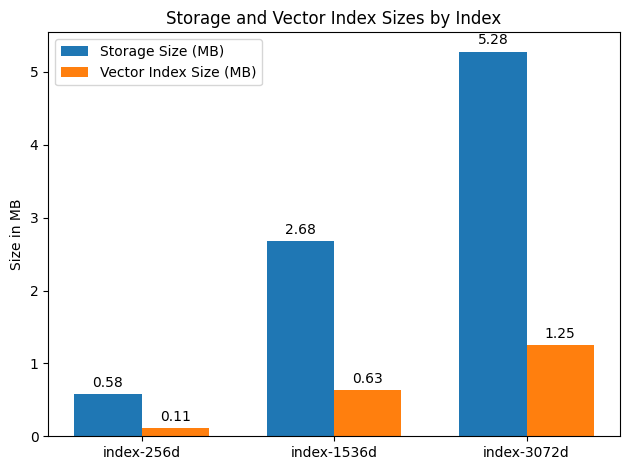

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Index names
index_names = ['index-256d', 'index-1536d', 'index-3072d']

# Storage sizes in MB (for demonstration, replace these with your actual values)
storage_sizes = [0.58, 2.68, 5.28]

# Vector index sizes in MB (for demonstration, replace these with your actual values)
vector_index_sizes = [0.11, 0.63, 1.25]

# Setting the positions and width for the bars
pos = np.arange(len(index_names))
width = 0.35

# Plotting both the storage size and vector index size in the same chart
fig, ax = plt.subplots()
bar1 = ax.bar(pos - width/2, storage_sizes, width, label='Storage Size (MB)')
bar2 = ax.bar(pos + width/2, vector_index_sizes, width, label='Vector Index Size (MB)')

# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Size in MB')
ax.set_title('Storage and Vector Index Sizes by Index')
ax.set_xticks(pos)
ax.set_xticklabels(index_names)
ax.legend()

# Adding a legend
ax.legend()

# Function to add labels on top of the bars
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function for each bar
autolabel(bar1)
autolabel(bar2)

# Show the plot
plt.tight_layout()
plt.show()


## Azure AI Search Index Statistics

Below is a summary table of the Azure AI Search indexes, showing the storage size and vector index size in megabytes (MB), along with the document count for each index:

| Index Name  | Storage Size (MB) | Vector Index Size (MB) | Document Count |
|-------------|-------------------|------------------------|----------------|
| index-256d  | 0.58              | 0.11                   | 106            |
| index-1536d | 2.68              | 0.63                   | 106            |
| index-3072d | 5.28              | 1.25                   | 106            |

### Insights:
- **Storage Size (MB)** and **Vector Index Size (MB)** are approximations, calculated from bytes to MB (1 MB = 1,048,576 bytes). View our [Vector index size documentation](https://learn.microsoft.com/en-us/azure/search/vector-search-index-size?tabs=portal-vector-quota) to learn more. 
- The **Document Count** indicates the total number of chunks/documents stored in each index.
- These statistics highlight the relationship between the dimensionality of the embeddings and the storage requirements. As the dimensionality increases, so does the storage and vector index size, reflecting the trade-off between detail (or accuracy) and resource utilization.
- **Relative Differences**:
    - The **index-1536d** is approximately **4.6x larger** in storage size and **5.7x larger** in vector index size than the **index-256d**.
    - The **index-3072d** is approximately **2x larger** in storage size and **2x larger** in vector index size than the **index-1536d**, showcasing the significant impact of increasing the embedding dimensionality on storage and indexing resource requirements.

These comparative insights demonstrate how embedding dimensionality influences not just the accuracy and detail of stored embeddings but also the practical aspects of storage and indexing within Azure AI Search, emphasizing the need to balance between embedding detail and resource efficiency.
